**In this notebook, I have trained different models with combination of 09 and 67 dataset only and assesed their performance on 75 and 46 dataset for validation.**

If this code will running on the google colab, please run the below code. If not, ignore it.

In [1]:
pip install h5py scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gp_minimize

In [2]:
# ROC
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [72]:
import pickle

In [36]:
data=pd.read_csv("CAD_Healthy_DEMs_Exp.csv")
data.index=data['Unnamed: 0']
data=data.drop(['Unnamed: 0'], axis=1)
data=data.T

In [37]:
# Normallization

for i in range(0,250):
    for j in range(0,9):
        data.iloc[i][j] = data.iloc[i][j]/data.iloc[i][9]

In [38]:
data.drop(['8087252 (norm)'], axis=1, inplace=True)
data['Status']=["H"]*51 + ["C"]*60 + ["M"]*139
data['Dataset']=['75']*5 + ['09']*46 + ['46']*14 + ['67']*46 + ['46']*28 + ['67']*111

In [39]:
data

Unnamed: 0,7900488,7916984,7923976,7969574,7971661,8008885,8084755,8087881,8163107,Status,Dataset
75.GSM1316371.H,0.821482,0.953340,0.614379,1.210115,0.838021,1.269683,0.500992,1.049844,1.023894,H,75
75.GSM1316372.H,0.835394,1.006169,0.591621,1.230080,0.872639,1.346317,0.549175,1.087701,1.044409,H,75
75.GSM1316373.H,0.980863,1.025993,0.694358,1.310815,0.954941,1.446121,0.592576,1.142362,1.155256,H,75
75.GSM1316374.H,0.904456,0.901394,0.638693,1.243170,0.946500,1.364252,0.571343,1.109096,0.985921,H,75
75.GSM1316375.H,0.790590,0.932724,0.561555,1.195788,0.896717,1.217840,0.508136,1.028521,0.983547,H,75
...,...,...,...,...,...,...,...,...,...,...,...
67.GSM1448706.M,1.283033,1.139121,0.842508,1.543433,1.159984,1.696429,0.735167,1.176757,1.255723,M,67
67.GSM1448710.M,1.098967,1.066525,0.708614,1.406780,0.944209,1.586826,0.655958,1.111460,1.182725,M,67
67.GSM1448714.M,1.114043,1.097254,0.813784,1.472832,1.031049,1.496085,0.595440,1.112559,1.245398,M,67
67.GSM1448718.M,1.080390,1.062306,0.784111,1.512735,1.032643,1.682794,0.656581,1.067695,1.227891,M,67


In [40]:
data['Status'].value_counts(), data['Dataset'].value_counts()

(M    139
 C     60
 H     51
 Name: Status, dtype: int64,
 67    157
 09     46
 46     42
 75      5
 Name: Dataset, dtype: int64)

# Exploratory Data Analysis

In [41]:
data.shape

(250, 11)

In [42]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,,,,,,,,
7900488,250.0,1.066969,0.116340,0.720585,1.023136,1.100019,1.145340,1.283033
7916984,250.0,1.080419,0.105178,0.723044,1.027844,1.101873,1.156875,1.250222
7923976,250.0,0.766803,0.092008,0.522439,0.735459,0.791198,0.827043,0.924059
7969574,250.0,1.361486,0.103901,1.095644,1.336135,1.386280,1.430252,1.554809
7971661,250.0,0.973975,0.105058,0.700240,0.929114,0.991027,1.035496,1.225783
8008885,250.0,1.514615,0.174990,0.956648,1.408964,1.554265,1.633042,1.835928
8084755,250.0,0.677780,0.095619,0.469142,0.619410,0.697222,0.745200,0.854820
8087881,250.0,1.117125,0.107976,0.740013,1.061921,1.148477,1.186825,1.337902
8163107,250.0,1.186332,0.166469,0.670049,1.144148,1.245006,1.295443,1.429198


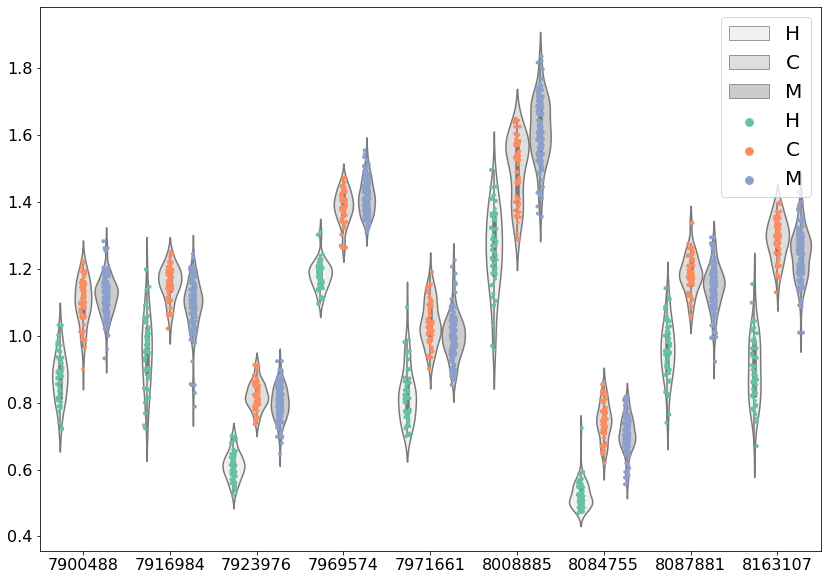

In [43]:
data_melt=pd.melt(data.drop(['Dataset'], axis=1), id_vars='Status')
plt.figure(figsize=(14,10))
sns.violinplot(x="Unnamed: 0", y="value", hue='Status', data=data_melt, color=".8");
sns.stripplot(x="Unnamed: 0", y="value", hue='Status', data=data_melt, size=4,  palette="Set2",
               jitter=True, linewidth=0, dodge=True)
plt.ylabel('', fontsize = 20)
plt.xlabel('', fontsize = 20)
plt.legend(loc='upper right', prop={'size':20})
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('Expressionforall.pdf', bbox_inches='tight')

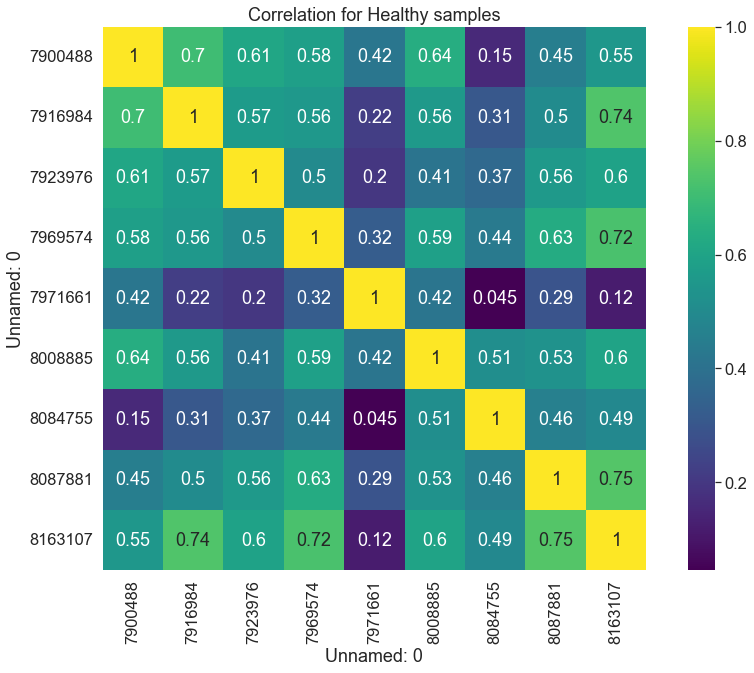

In [44]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
df=data[data['Status'] == "H"].drop(['Status', 'Dataset'], axis=1)
sns.heatmap(df.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation for Healthy samples')
plt.savefig('corrforH.pdf', bbox_inches='tight')

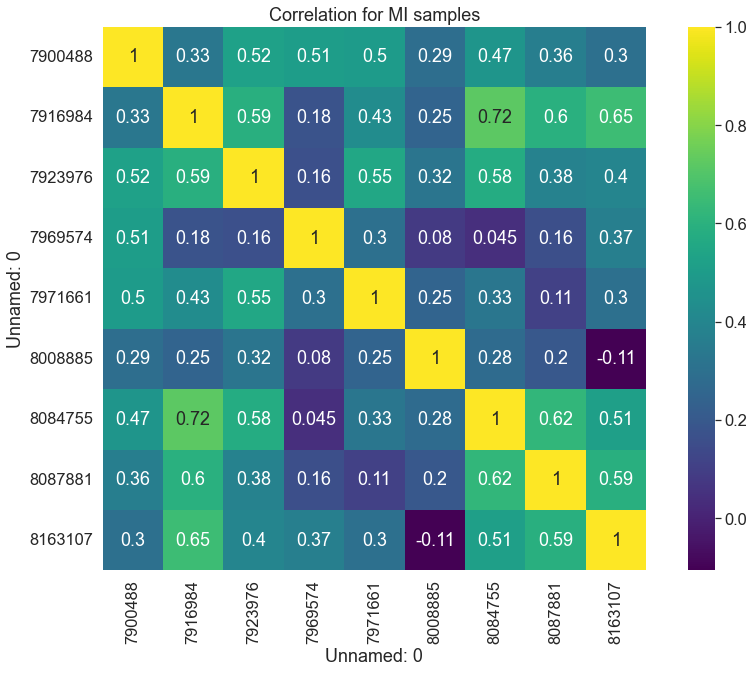

In [45]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
df=data[data['Status'] == "M"].drop(['Status', 'Dataset'], axis=1)
sns.heatmap(df.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation for MI samples')
plt.savefig('corrforM.pdf', bbox_inches='tight')

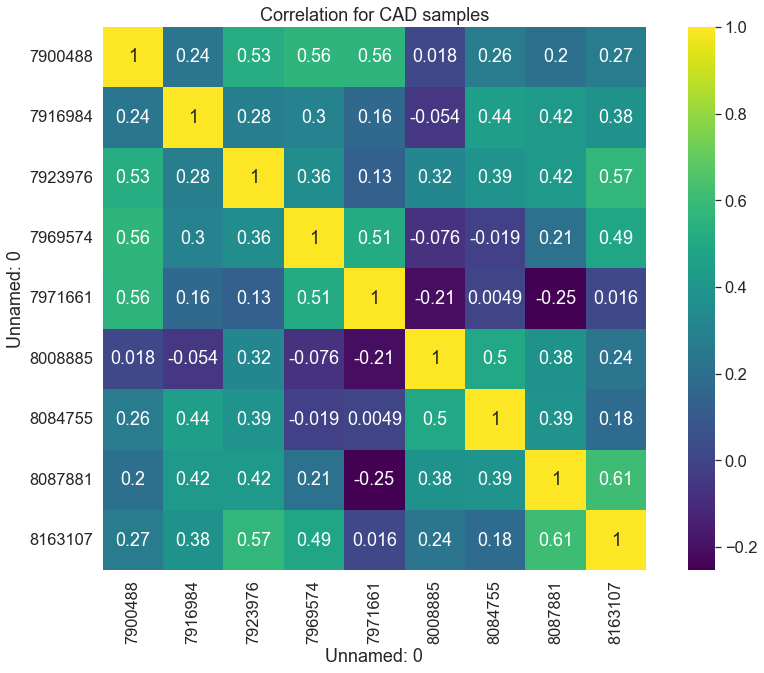

In [46]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1.5)
df=data[data['Status'] == "C"].drop(['Status', 'Dataset'], axis=1)
sns.heatmap(df.corr(),vmax=1,square=True, annot=True, cmap='viridis')
plt.title('Correlation for CAD samples')
plt.savefig('corrforC.pdf', bbox_inches='tight')

# Seperating two sets for train and test set

In [47]:
train_data=data[data['Dataset']=='67']
train_data=pd.concat([train_data, data[data['Dataset']=='09']], axis=0)
train_data.drop(['Dataset'], axis=1, inplace=True)

In [48]:
test_data=data[data['Dataset']=='46']
test_data=pd.concat([test_data, data[data['Dataset']=='75']], axis=0)
test_data.drop(['Dataset'], axis=1, inplace=True)

In [49]:
test_data.tail()

Unnamed: 0,7900488,7916984,7923976,7969574,7971661,8008885,8084755,8087881,8163107,Status
75.GSM1316371.H,0.821482,0.953340,0.614379,1.210115,0.838021,1.269683,0.500992,1.049844,1.023894,H
75.GSM1316372.H,0.835394,1.006169,0.591621,1.230080,0.872639,1.346317,0.549175,1.087701,1.044409,H
75.GSM1316373.H,0.980863,1.025993,0.694358,1.310815,0.954941,1.446121,0.592576,1.142362,1.155256,H
75.GSM1316374.H,0.904456,0.901394,0.638693,1.243170,0.946500,1.364252,0.571343,1.109096,0.985921,H
75.GSM1316375.H,0.790590,0.932724,0.561555,1.195788,0.896717,1.217840,0.508136,1.028521,0.983547,H


In [50]:
train_data['Status'].value_counts(), test_data['Status'].value_counts()

(M    111
 C     46
 H     46
 Name: Status, dtype: int64,
 M    28
 C    14
 H     5
 Name: Status, dtype: int64)

# Healthy or MI/CAD

## Training a linear SVM model for all miRs

In [51]:
scoring = ['precision_weighted', 'accuracy']

In [61]:
mirs=list(train_data.columns)[0:9]
new_target=["nH"]*157 + ["H"]*46
result=[]
for mir in mirs:
  X_temp=pd.DataFrame(train_data[mir])
  y_temp=new_target
  cv=StratifiedKFold(n_splits=10)
  svm=SVC(kernel='rbf', random_state=1)
  scores = cross_validate(svm, X_temp, y_temp, scoring=scoring, cv=cv,
                          n_jobs=-1, return_train_score=True)
  scores=pd.DataFrame(scores)
  result.append([mir, list(scores.mean(axis=0))])

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
result

[['7900488',
  [0.0036009073257446287,
   0.0024364948272705077,
   0.9655012004801922,
   0.9611662506520533,
   0.9604761904761905,
   0.9611391340899538]],
 ['7916984',
  [0.00423424243927002,
   0.0022407293319702147,
   0.8539472025652366,
   0.8705402288049472,
   0.8661904761904762,
   0.8757401068876479]],
 ['7923976',
  [0.002051901817321777,
   0.0015813112258911133,
   0.9816220238095237,
   0.9763678422624281,
   0.9799999999999999,
   0.9764576953101545]],
 ['7969574',
  [0.0020125389099121095,
   0.0012215852737426757,
   0.9913442460317461,
   0.9951076034717227,
   0.9902380952380951,
   0.9950729598270582]],
 ['7971661',
  [0.0035770893096923827,
   0.0014072656631469727,
   0.9538815943043885,
   0.9528986862151397,
   0.9504761904761905,
   0.9523809523809523]],
 ['8008885',
  [0.002487492561340332,
   0.0012796401977539062,
   0.9218818645879405,
   0.9236548103711038,
   0.8980952380952381,
   0.9244670629916533]],
 ['8084755',
  [0.0024021148681640627,
   0.001384

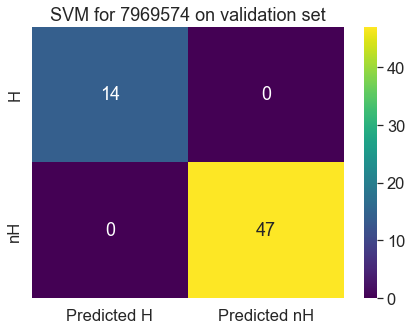

In [63]:
#Confusion Matrix for 7969574
X_temp=pd.DataFrame(train_data['7969574'])
y_temp = new_target
X_train, X_validation, y_train, y_validation = train_test_split(X_temp, y_temp, test_size=0.3, 
                                                                random_state=1, stratify=y_temp)
svm=SVC(kernel='rbf', random_state=1).fit(X_train, y_train)
pred=svm.predict(X_validation)
cm=confusion_matrix(y_validation, pred, labels=['H', "nH"])
df_cm=pd.DataFrame(cm, index=[i for i in ['H', 'nH']], columns=[i for i in ['Predicted H', 'Predicted nH']])
plt.figure(figsize=(7,5))
plt.title('SVM for 7969574 on validation set')
sns.heatmap(df_cm,annot=True, cmap='viridis');
plt.savefig('CM for H and nH by 7969574 on train.pdf')

In [64]:
test_data['Status'].value_counts()

M    28
C    14
H     5
Name: Status, dtype: int64

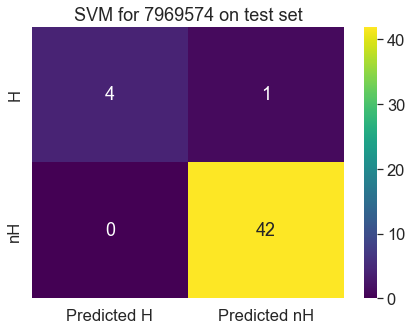

In [65]:
#Confusion Matrix for 7969574 on test set (75 and 46)

X_test=pd.DataFrame(test_data['7969574'])
y_test=["nH"]*42 + ["H"]*5

pred=svm.predict(X_test)
cm=confusion_matrix(y_test, pred, labels=['H', "nH"])
df_cm=pd.DataFrame(cm, index=[i for i in ['H', 'nH']], columns=[i for i in ['Predicted H', 'Predicted nH']])
plt.figure(figsize=(7,5))
plt.title('SVM for 7969574 on test set')
sns.heatmap(df_cm,annot=True, cmap='viridis');
plt.savefig('CM for H and nH by 7969574 on test set.pdf')

In [66]:
svm.score(X_train, y_train), svm.score(X_validation, y_validation), svm.score(X_test, y_test)

(0.9929577464788732, 1.0, 0.9787234042553191)

## Last Model Training and extracting deployment file

### For 7969574

In [67]:
new_target=["nH"]*157 + ["H"]*46
X_temp=pd.DataFrame(train_data['7969574'])
y_temp = new_target

svm_7969574=SVC(kernel='linear', random_state=1).fit(X_temp, y_temp)

In [68]:
X_test=pd.DataFrame(test_data['7969574'])
y_test=["nH"]*42 + ["H"]*5

In [70]:
svm_7969574.score(X_temp, y_temp), svm_7969574.score(X_test, y_test)

(0.9950738916256158, 0.9574468085106383)

In [73]:
# Extracting model file

pickle_out=open('svm_7969574_norm.pkl', "wb")
pickle.dump(svm_7969574, pickle_out)
pickle_out.close()

### For 7971661

In [27]:
new_target=["nH"]*157 + ["H"]*46
X_temp=pd.DataFrame(train_data[7971661])
y_temp = new_target

svm_7971661=SVC(kernel='linear', random_state=1).fit(X_temp, y_temp)

In [74]:
new_target=["nH"]*157 + ["H"]*46
X_temp=train_data[['8008885', '7971661']]
y_temp = new_target

svm_7971661=SVC(kernel='rbf', random_state=1).fit(X_temp, y_temp)

In [75]:
X_test=test_data[['8008885', '7971661']]
y_test=["nH"]*42 + ["H"]*5

In [76]:
svm_7971661.score(X_temp, y_temp), svm_7971661.score(X_test, y_test)

(0.9655172413793104, 0.9574468085106383)

In [77]:
pickle_out=open('svm_8008885_7971661_norm.pkl', "wb")
pickle.dump(svm_7971661, pickle_out)
pickle_out.close()

# MI or CAD? This is the problem

In [78]:
# Seperating MI and CAD data from Healthy samples.

train_data_mc=train_data[train_data['Status'] != 'H']
test_data_mc=test_data[test_data['Status'] != 'H']

train_data_mc['Status'].value_counts(), test_data_mc['Status'].value_counts()

(M    111
 C     46
 Name: Status, dtype: int64,
 M    28
 C    14
 Name: Status, dtype: int64)

In [79]:
X=train_data_mc.drop('Status', axis=1)
y=train_data_mc['Status']

In [80]:
X_final_test=test_data_mc.drop('Status', axis=1)
y_final_test=test_data_mc['Status']

## Gradiant Boost

### Training a Gradiant Boost model with all 8 microRNAs

In [81]:
GB_basic=GradientBoostingClassifier(random_state=1)
cv=StratifiedKFold(n_splits=10)
scores = cross_validate(GB_basic, X, y, scoring=scoring, cv=cv, n_jobs=-1, 
                        return_train_score=True, return_estimator=True)
scores1=pd.DataFrame(scores)
scores1.mean(axis=0)

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/74/0r2lyhkj3b51z9c9__s718s80000gn/T/ipykernel_2167/211560386.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  scores1.mean(axis=0)


fit_time                    0.065374
score_time                  0.002049
test_precision_weighted     0.754401
train_precision_weighted    1.000000
test_accuracy               0.779167
train_accuracy              1.000000
dtype: float64

### Finding the most important mirs and training a GB model with them

In [82]:
# Selecting the most important miRNAs by finding the most repeated ones in all 10 cross validation

mirs_importance=[0]*9
for idx,estimator in enumerate(scores['estimator']):
    mirs_importance+=estimator.feature_importances_

    
mirs_importance=pd.DataFrame(mirs_importance, index=X.columns).sort_values(by=[0], ascending=False)
mirs_importance.T

Unnamed: 0,8008885,7916984,7971661,8084755,8087881,7969574,7900488,8163107,7923976
0,3.43405,2.369955,0.986996,0.848301,0.795004,0.718944,0.545188,0.239814,0.061749


As it is clear, with the logic of summation of feature importance in all 10 cross-validations, mirs with probe no. 7916984, 8008885, 7971661, 7969574, and 8087881 are the most important mirs. 
In the following a gradint boost model has been trained using the first 3 ones.

In [120]:
X_temp=train_data_mc[['7916984', '8008885', '7971661']]
y_temp=train_data_mc['Status']

### Using scikit optimize package

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=0, stratify=y_temp)

X_train.shape, X_test.shape

((109, 3), (48, 3))

In [122]:
# determine the hyperparameter space

param_grid = [
    Integer(10, 300, name="n_estimators"),
    Integer(2, 5, name="max_depth"),
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'),
    Real(0.001, 0.999, prior='log-uniform', name="min_samples_split"),
    Categorical(['deviance', 'exponential'], name="loss"),
]

# Scikit-optimize parameter grid is a list
type(param_grid)

list

In [123]:
gbm = GradientBoostingClassifier(random_state=0)

In [124]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement for scikit-optimize.

@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=10,
            n_jobs=-1,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

In [125]:
# gbrt_minimize performs by Bayesian Optimization 
# using GBMs as surrogate for f(x)

gbm_ = gbrt_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=500, # the number of subsequent evaluations of f(x)
    random_state=0, 
    n_jobs=6,
)

In [126]:
"Best score=%.4f" % gbm_.fun

'Best score=-0.8709'

In [127]:
dim_names = ['n_estimators', 'max_depth', 'min_samples_split', 'learning_rate', 'loss']
# all together in one dataframe, so we can investigate further

tmp = pd.concat([
    pd.DataFrame(gbm_.x_iters),
    pd.Series(gbm_.func_vals),
], axis=1)

tmp.columns = dim_names + ['accuracy']
tmp.sort_values(by=['accuracy']).head()

,n_estimators,max_depth,min_samples_split,learning_rate,loss,accuracy
381,246,5,0.019130,0.766155,deviance,-0.870909
286,270,5,0.019860,0.768380,deviance,-0.861818
355,246,4,0.019655,0.746600,deviance,-0.861818
464,226,5,0.019925,0.750904,deviance,-0.861818
386,294,5,0.021152,0.792112,deviance,-0.861818


In [128]:
print("""Best parameters:
=========================
- n_estimators = %d
- max-depth = %d
- min_samples_split = %.3f
- learning_rate = %.3f
- loss = %s""" % (gbm_.x[0],
                  gbm_.x[1],
                  gbm_.x[2],
                  gbm_.x[3],
                  gbm_.x[4]))

Best parameters:
- n_estimators = 246
- max-depth = 5
- min_samples_split = 0.019
- learning_rate = 0.766
- loss = deviance


### Training GB with the best 3

In [129]:
sample_weight=np.zeros(len(y_train))
for i in range(0, 50):
    a=0.1
    a+=i*0.05
    sample_weight[y_train == 'M'] = a
    sample_weight[y_train == 'C'] = 1
    GB_basic=GradientBoostingClassifier(n_estimators=246, max_depth=5, min_samples_split=0.19,
                                     learning_rate=0.766, loss='deviance', random_state=1)
    GB_basic.fit(X_train, y_train, sample_weight=sample_weight)
    print('%.2f' % a, '%.3f' % GB_basic.score(X_test, y_test), GB_basic.score(X_train, y_train),
         '%.3f' % GB_basic.score(X_final_test[['7916984', '8008885', '7971661']], y_final_test))

0.10 0.833 1.0 0.857
0.15 0.833 1.0 0.857
0.20 0.833 1.0 0.857
0.25 0.833 1.0 0.857
0.30 0.854 1.0 0.881
0.35 0.833 1.0 0.857
0.40 0.812 1.0 0.857
0.45 0.833 1.0 0.905
0.50 0.854 1.0 0.881
0.55 0.854 1.0 0.881
0.60 0.854 1.0 0.905
0.65 0.854 1.0 0.881
0.70 0.833 1.0 0.857
0.75 0.854 1.0 0.881
0.80 0.854 1.0 0.881
0.85 0.854 1.0 0.881
0.90 0.833 1.0 0.881
0.95 0.792 1.0 0.857
1.00 0.854 1.0 0.881
1.05 0.854 1.0 0.881
1.10 0.854 1.0 0.881
1.15 0.812 1.0 0.857
1.20 0.812 1.0 0.857
1.25 0.833 1.0 0.857
1.30 0.854 1.0 0.905
1.35 0.854 1.0 0.881
1.40 0.792 1.0 0.857
1.45 0.771 1.0 0.857
1.50 0.833 1.0 0.857
1.55 0.833 1.0 0.857
1.60 0.792 1.0 0.857
1.65 0.854 1.0 0.881
1.70 0.833 1.0 0.881
1.75 0.854 1.0 0.881
1.80 0.812 1.0 0.857
1.85 0.854 1.0 0.881
1.90 0.833 1.0 0.857
1.95 0.833 1.0 0.881
2.00 0.854 1.0 0.881
2.05 0.854 1.0 0.881
2.10 0.812 1.0 0.857
2.15 0.812 1.0 0.857
2.20 0.833 1.0 0.857
2.25 0.833 1.0 0.857
2.30 0.792 1.0 0.857
2.35 0.833 1.0 0.857
2.40 0.812 1.0 0.857
2.45 0.812 1.

In [130]:
sample_weight=np.zeros(len(y_train))
sample_weight[y_train == 'M'] = 1.3
sample_weight[y_train == 'C'] = 1

In [131]:
GB_basic=GradientBoostingClassifier(n_estimators=246, max_depth=5, min_samples_split=0.19,
                                     learning_rate=0.766, loss='deviance', random_state=1)


GB_basic.fit(X_train, y_train, sample_weight=sample_weight)

GradientBoostingClassifier(learning_rate=0.766, max_depth=5,
                           min_samples_split=0.19, n_estimators=246,
                           random_state=1)

In [132]:
GB_basic.score(X_test, y_test)

0.8541666666666666

In [133]:
GB_basic.score(X_train, y_train)

1.0

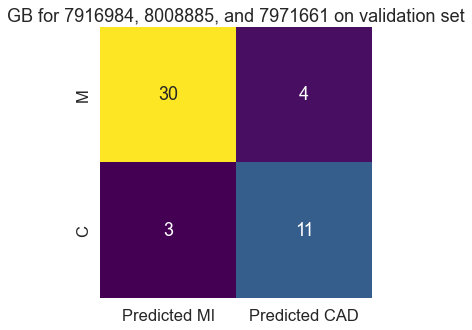

In [134]:
pred=GB_basic.predict(X_test)
cm=confusion_matrix(y_test,pred,labels=['M', "C"])
df_cm=pd.DataFrame(cm,index=[i for i in ['M', 'C']],columns=[i for i in ['Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('GB for 7916984, 8008885, and 7971661 on validation set')
sns.heatmap(df_cm,annot=True, cmap='viridis', cbar=False, square=True);
plt.savefig('GB for 7916984, 8008885, and 7971661on validation set.pdf')

In [135]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           C       0.73      0.79      0.76        14
           M       0.91      0.88      0.90        34

    accuracy                           0.85        48
   macro avg       0.82      0.83      0.83        48
weighted avg       0.86      0.85      0.86        48



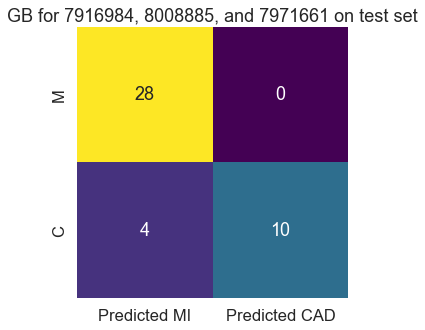

In [136]:
# Real test

pred=GB_basic.predict(X_final_test[['7916984', '8008885', '7971661']])
cm=confusion_matrix(y_final_test,pred,labels=['M', "C"])
df_cm=pd.DataFrame(cm, index=[i for i in ['M', 'C']], columns=[i for i in ['Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('GB for 7916984, 8008885, and 7971661 on test set')
sns.heatmap(df_cm,annot=True, cmap='viridis', cbar=False, square=True);
plt.savefig('GB for 7916984, 8008885, and 7971661 on test set.pdf')

In [137]:
print(classification_report(y_final_test, pred))

              precision    recall  f1-score   support

           C       1.00      0.71      0.83        14
           M       0.88      1.00      0.93        28

    accuracy                           0.90        42
   macro avg       0.94      0.86      0.88        42
weighted avg       0.92      0.90      0.90        42



In [138]:
GB_basic.score(X_final_test[['7916984', '8008885', '7971661']], y_final_test)

0.9047619047619048

### Training a model on all training data and then testing on test set

In [139]:
X_temp=X[['7916984', '8008885', '7971661']]
y_temp=y.copy()

In [141]:
sample_weight=np.zeros(len(y_temp))
for i in range(0, 50):
    a=0.1
    a+=i*0.05
    sample_weight[y_temp == 'M'] = a
    sample_weight[y_temp == 'C'] = 1
    GB_basic=GradientBoostingClassifier(n_estimators=246, max_depth=5, min_samples_split=0.19,
                                     learning_rate=0.766, loss='deviance', random_state=1)
    GB_basic.fit(X_temp, y_temp, sample_weight=sample_weight)
    print('%.2f' % a, '%.3f' % GB_basic.score(X_temp, y_temp),
         '%.3f' % GB_basic.score(X_final_test[['7916984', '8008885', '7971661']], y_final_test))

0.10 1.000 0.952
0.15 1.000 0.929
0.20 1.000 0.976
0.25 1.000 0.976
0.30 1.000 0.952
0.35 1.000 0.952
0.40 1.000 0.952
0.45 1.000 0.952
0.50 1.000 0.976
0.55 1.000 0.952
0.60 1.000 0.976
0.65 1.000 0.976
0.70 1.000 0.952
0.75 1.000 0.952
0.80 1.000 0.976
0.85 1.000 0.952
0.90 1.000 0.976
0.95 1.000 0.952
1.00 1.000 0.952
1.05 1.000 0.952
1.10 1.000 0.976
1.15 1.000 0.976
1.20 1.000 0.952
1.25 1.000 0.952
1.30 1.000 0.929
1.35 1.000 0.952
1.40 1.000 0.976
1.45 1.000 0.976
1.50 1.000 0.976
1.55 1.000 0.976
1.60 1.000 0.976
1.65 1.000 0.952
1.70 1.000 0.952
1.75 1.000 0.952
1.80 1.000 0.976
1.85 1.000 0.952
1.90 1.000 0.952
1.95 1.000 0.952
2.00 1.000 0.976
2.05 1.000 0.952
2.10 1.000 0.976
2.15 1.000 0.976
2.20 1.000 0.952
2.25 1.000 0.929
2.30 1.000 0.952
2.35 1.000 0.952
2.40 1.000 0.976
2.45 1.000 0.952
2.50 1.000 0.952
2.55 1.000 0.952


In [142]:
sample_weight=np.zeros(len(y_temp))
sample_weight[y_temp == 'M'] = 1.10
sample_weight[y_temp == 'C'] = 1

In [143]:
GB_basic=GradientBoostingClassifier(n_estimators=246, max_depth=5, min_samples_split=0.19,
                                     learning_rate=0.766, loss='deviance', random_state=1)


GB_basic.fit(X_temp, y_temp, sample_weight=sample_weight)

GradientBoostingClassifier(learning_rate=0.766, max_depth=5,
                           min_samples_split=0.19, n_estimators=246,
                           random_state=1)

In [144]:
GB_basic.score(X_temp, y_temp)

1.0

In [147]:
GB_basic.score(X_final_test[['7916984', '8008885', '7971661']], y_final_test)

0.9761904761904762

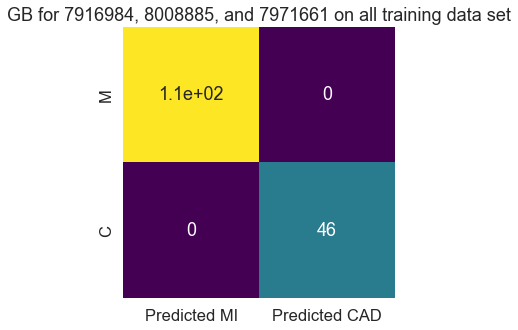

In [148]:
pred=GB_basic.predict(X_temp)
cm=confusion_matrix(y_temp,pred,labels=['M', "C"])
df_cm=pd.DataFrame(cm,index=[i for i in ['M', 'C']],columns=[i for i in ['Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('GB for 7916984, 8008885, and 7971661 on all training data set')
sns.heatmap(df_cm,annot=True, cmap='viridis', cbar=False, square=True);
plt.savefig('GB for 7916984, 8008885, and 7971661 on all trainin data.pdf')

In [149]:
print(classification_report(y_temp, pred))

              precision    recall  f1-score   support

           C       1.00      1.00      1.00        46
           M       1.00      1.00      1.00       111

    accuracy                           1.00       157
   macro avg       1.00      1.00      1.00       157
weighted avg       1.00      1.00      1.00       157



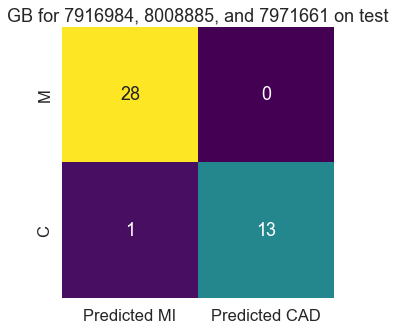

In [150]:
# Real test

pred=GB_basic.predict(X_final_test[['7916984', '8008885', '7971661']])
cm=confusion_matrix(y_final_test,pred,labels=['M', "C"])
df_cm=pd.DataFrame(cm, index=[i for i in ['M', 'C']], columns=[i for i in ['Predicted MI', 'Predicted CAD']])
plt.figure(figsize=(7,5))
plt.title('GB for 7916984, 8008885, and 7971661 on test')
sns.heatmap(df_cm,annot=True, cmap='viridis', cbar=False, square=True);
plt.savefig('GB for 7916984, 8008885, and 7971661on test set after training with all data.pdf')

In [151]:
print(classification_report(y_final_test, pred))

              precision    recall  f1-score   support

           C       1.00      0.93      0.96        14
           M       0.97      1.00      0.98        28

    accuracy                           0.98        42
   macro avg       0.98      0.96      0.97        42
weighted avg       0.98      0.98      0.98        42



In [152]:
pickle_out=open('GB_normal.pkl', "wb")
pickle.dump(GB_basic, pickle_out)
pickle_out.close()

#### ROC

In [204]:
label = LabelEncoder()

y_temp = label.fit_transform(train_data_mc['Status'])
y_temp = pd.get_dummies(y_temp)
y_temp.columns = ['CAD', 'MI']

y_test=label.fit_transform(y_final_test)
y_test = pd.get_dummies(y_test)
y_test.columns = ['CAD', 'MI']

n_classes = y_temp.shape[1]

In [205]:
X_final_test.shape

(42, 9)

In [206]:
model = GradientBoostingClassifier(n_estimators=169, max_depth=4, min_samples_split=0.031,
                                     learning_rate=0.22, loss='deviance', random_state=1)

X_train=X_temp
X_test=X_final_test[[7916984, 8008885, 7971661]]
y_train=y_temp


# Learn to predict each class against the other
classifier = OneVsRestClassifier(model)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/var/folders/74/0r2lyhkj3b51z9c9__s718s80000gn/T/ipykernel_820/2808089666.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


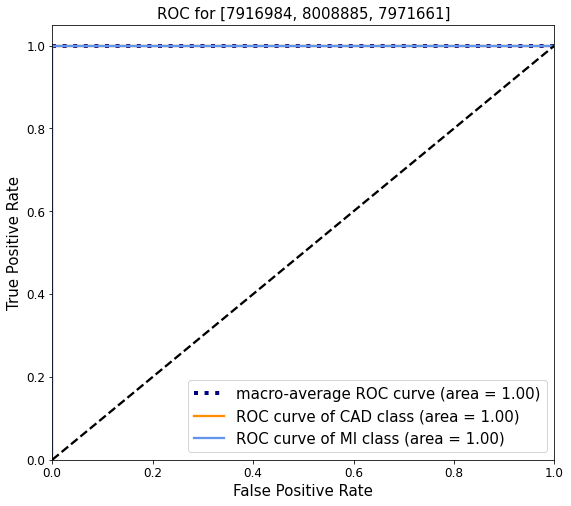

In [207]:
lw = 2.3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    
# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(9,8))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(['darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} class (area = {1:0.2f})'
             ''.format(list(y_temp.columns)[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC for {0}'''.format(list(X_test.columns)), fontsize = 15)
plt.legend(loc="lower right", prop={'size':15})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig("GB for 7916984, 8008885, and 7971661 using all data.pdf")

## XGB

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
label_encoder = label_encoder.fit(y)
y_binary = label_encoder.transform(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=0, stratify=y_binary)

X_train.shape, X_test.shape

((109, 9), (48, 9))

In [28]:
xgb_base=xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42, scale_pos_weight=(46/111))

xgb_base.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.892367
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.938718
[2]	validation_0-aucpr:0.945407
[3]	validation_0-aucpr:0.946975
[4]	validation_0-aucpr:0.956781
[5]	validation_0-aucpr:0.951521
[6]	validation_0-aucpr:0.962556
[7]	validation_0-aucpr:0.970914
[8]	validation_0-aucpr:0.967355
[9]	validation_0-aucpr:0.96605
[10]	validation_0-aucpr:0.964074
[11]	validation_0-aucpr:0.965092
[12]	validation_0-aucpr:0.965092
[13]	validation_0-aucpr:0.963926
[14]	validation_0-aucpr:0.965404
[15]	validation_0-aucpr:0.962414
[16]	validation_0-aucpr:0.959957
[17]	validation_0-aucpr:0.955958
Stopping. Best iteration:
[7]	validation_0-aucpr:0.970914



XGBClassifier(scale_pos_weight=0.4144144144144144, seed=42)

In [32]:
xgb_base.get_booster().get_score(importance_type='total_gain')

{'7900488': 0.918341041,
 '7916984': 142.97791098099995,
 '7923976': 10.3447120002,
 '7969574': 0.0715165138,
 '7971661': 4.034704571,
 '8008885': 81.28198195700003,
 '8084755': 13.284669159299998,
 '8087881': 12.859676469,
 '8163107': 6.9021956963}

In [33]:
xgb_base.get_booster().get_score(importance_type='gain')

{'7900488': 0.918341041,
 '7916984': 7.525153209526313,
 '7923976': 1.293089000025,
 '7969574': 0.0715165138,
 '7971661': 0.6724507618333333,
 '8008885': 3.126230075269232,
 '8084755': 1.4760743510333332,
 '8087881': 1.607459558625,
 '8163107': 0.6274723360272727}

Based on both total and average gain, 7916984, and 8008885 are the 2 most important mirs. After this two 8084755 and 8087881 are the most importants.


#### XGB model with 3 most important mirs

In [13]:
X_temp=X[[7916984, 8008885, 8087881]]
y_temp=y_binary

X_temp.shape

(157, 3)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=0, stratify=y_temp)

X_train.shape, X_test.shape

((109, 3), (48, 3))

In [37]:
# determine the hyperparameter space

param_grid = [
    Integer(3, 1000, name='n_estimators'),
    Integer(1, 10, name='max_depth'),
    Real(0.01, 0.99, name='learning_rate'),
    Categorical(['gbtree', 'dart'], name='booster'),
    Real(0.01, 10, name='gamma'),
    Real(0.50, 0.90, name='subsample'),
    Integer(1, 50, name='reg_lambda')
]

In [38]:
# set up the gradient boosting classifier

gbm = xgb.XGBClassifier(random_state=1000)

In [39]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=3,
            n_jobs=-1,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

### Bayesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization.

In [42]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=200, # the number of subsequent evaluations of f(x)
    random_state=0
)

In [43]:
"Best score=%.4f" % gp_.fun

'Best score=-0.8526'

In [45]:
print("""Best parameters:
=========================
- n_estimators = %d
- max_depth = %d
- learning_rate = %.6f
- booster = %s
- gamma = %.6f
- subsample = %.6f
- reg_lambda = %d
""" % (gp_.x[0],
       gp_.x[1],
       gp_.x[2],
       gp_.x[3],
       gp_.x[4],
       gp_.x[5],
       gp_.x[6]
      ))

Best parameters:
- n_estimators = 871
- max_depth = 7
- learning_rate = 0.019910
- booster = dart
- gamma = 2.240964
- subsample = 0.723084
- reg_lambda = 1



In [24]:
for i in range(0, 50):
    a=0.05
    a+=i*0.05
    final_xgb=xgb.XGBClassifier(objective='binary:logistic',
                           n_estimator=871,
                           max_depth=7,
                           learn_rate=0.02,
                           booster='dart',
                           gamma=2.24,
                           subsample=0.72,
                           reg_lambda=1,
                           scale_pos_weight=a)
    final_xgb.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])
    print('%.2f' % a,
         '%.3f' % final_xgb.score(X_final_test[[7916984, 8008885, 8087881]], y_binary_final_test))

[11:01:01] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.70833
[1]	validation_0-aucpr:0.70833
[2]	validation_0-aucpr:0.70833
[3]	validation_0-aucpr:0.87720
[4]	validation_0-aucpr:0.87720
[5]	validation_0-aucpr:0.87720
[6]	validation_0-aucpr:0.87720
[7]	validation_0-aucpr:0.87720
[8]	validation_0-aucpr:0.87720
[9]	validation_0-aucpr:0.87720
[10]	validation_0-aucpr:0.87720
[11]	validation_0-aucpr:0.87720
[12]	validation_0-aucpr:0.87720
[13]	validation_0-aucpr:0.87720
0.05 0.333
[11:01:01] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[7]	validation_0-aucpr:0.91597
[8]	validation_0-aucpr:0.91597
[9]	validation_0-aucpr:0.91211
[10]	validation_0-aucpr:0.91211
[11]	validation_0-aucpr:0.91211
[12]	validation_0-aucpr:0.91211
[13]	validation_0-aucpr:0.91211
[14]	validation_0-aucpr:0.91211
[15]	validation_0-aucpr:0.91211
[16]	validation_0-aucpr:0.91105
[17]	validation_0-aucpr:0.91156
0.30 0.833
[11:01:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86142
[1]	validation_0-aucpr:0.90505
[2]	validation_0-aucpr:0.91458
[3]	validation_0-aucpr:0.90512
[4]	validation_0-aucpr:0.90512
[5]	validation_0-aucpr:0.91204
[6]	validation_0-aucpr:0.91412
[7]	validation_0-aucpr:0.91337
[8]	validation_0

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[13]	validation_0-aucpr:0.91029
[14]	validation_0-aucpr:0.91029
[15]	validation_0-aucpr:0.91029
0.55 0.786
[11:01:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86142
[1]	validation_0-aucpr:0.88752
[2]	validation_0-aucpr:0.92458
[3]	validation_0-aucpr:0.91268
[4]	validation_0-aucpr:0.91207
[5]	validation_0-aucpr:0.91531
[6]	validation_0-aucpr:0.91443
[7]	validation_0-aucpr:0.91740
[8]	validation_0-aucpr:0.91740
[9]	validation_0-aucpr:0.91354
[10]	validation_0-aucpr:0.94902
[11]	validation_0-aucpr:0.94902
[12]	validation_0-aucpr:0.94902
[13]	validation_0-aucpr:0.94902
[14]	validation_0-aucpr:0.94902
[15]	validation_0-aucpr:0.94902
[16]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[17]	validation_0-aucpr:0.95034
[18]	validation_0-aucpr:0.95129
[19]	validation_0-aucpr:0.95129
[20]	validation_0-aucpr:0.95129
[21]	validation_0-aucpr:0.95129
[22]	validation_0-aucpr:0.95129
[23]	validation_0-aucpr:0.94949
[24]	validation_0-aucpr:0.94949
[25]	validation_0-aucpr:0.94949
[26]	validation_0-aucpr:0.94949
[27]	validation_0-aucpr:0.94949
[28]	validation_0-aucpr:0.95091
0.75 0.833
[11:01:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86142
[1]	validation_0-aucpr:0.88752
[2]	validation_0-aucpr:0.92085
[3]	validation_0-aucpr:0.92339
[4]	validation_0-aucpr:0.92420
[5]	validation_0-aucpr:0.92887
[6]	validation_0-aucpr:0.92451
[7]	validati

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

0.90 0.833
[11:01:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86142
[1]	validation_0-aucpr:0.88752
[2]	validation_0-aucpr:0.92662
[3]	validation_0-aucpr:0.92745
[4]	validation_0-aucpr:0.92825
[5]	validation_0-aucpr:0.93136
[6]	validation_0-aucpr:0.92892
[7]	validation_0-aucpr:0.92682
[8]	validation_0-aucpr:0.92880
[9]	validation_0-aucpr:0.93115
[10]	validation_0-aucpr:0.95401
[11]	validation_0-aucpr:0.95401
[12]	validation_0-aucpr:0.95401
[13]	validation_0-aucpr:0.95233
[14]	validation_0-aucpr:0.95233
[15]	validation_0-aucpr:0.95105
[16]	validation_0-aucpr:0.95300
[17]	validation_0-aucpr:0.95300
[18]	validation_0-aucpr:0.95427
[19]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[3]	validation_0-aucpr:0.92644
[4]	validation_0-aucpr:0.92854
[5]	validation_0-aucpr:0.93012
[6]	validation_0-aucpr:0.92688
[7]	validation_0-aucpr:0.92634
[8]	validation_0-aucpr:0.92678
[9]	validation_0-aucpr:0.92803
[10]	validation_0-aucpr:0.95097
[11]	validation_0-aucpr:0.95097
[12]	validation_0-aucpr:0.95097
[13]	validation_0-aucpr:0.94839
[14]	validation_0-aucpr:0.94902
[15]	validation_0-aucpr:0.94902
[16]	validation_0-aucpr:0.94902
[17]	validation_0-aucpr:0.94902
[18]	validation_0-aucpr:0.94814
[19]	validation_0-aucpr:0.94814
1.10 0.810
[11:01:02] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86142
[1]	validation_0-aucpr:0.88752
[2]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[5]	validation_0-aucpr:0.92988
[6]	validation_0-aucpr:0.92617
[7]	validation_0-aucpr:0.92694
[8]	validation_0-aucpr:0.92715
[9]	validation_0-aucpr:0.93033
[10]	validation_0-aucpr:0.95323
[11]	validation_0-aucpr:0.95323
[12]	validation_0-aucpr:0.95236
[13]	validation_0-aucpr:0.95236
[14]	validation_0-aucpr:0.95242
[15]	validation_0-aucpr:0.95242
[16]	validation_0-aucpr:0.95242
[17]	validation_0-aucpr:0.95242
[18]	validation_0-aucpr:0.95242
[19]	validation_0-aucpr:0.95242
1.30 0.833
[11:01:03] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86626
[1]	validation_0-aucpr:0.88989
[2]	validation_0-aucpr:0.90980
[3]	validation_0-aucpr:0.91227
[4]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[3]	validation_0-aucpr:0.91360
[4]	validation_0-aucpr:0.92891
[5]	validation_0-aucpr:0.93250
[6]	validation_0-aucpr:0.92756
[7]	validation_0-aucpr:0.92702
[8]	validation_0-aucpr:0.92702
[9]	validation_0-aucpr:0.92804
[10]	validation_0-aucpr:0.95446
[11]	validation_0-aucpr:0.95298
[12]	validation_0-aucpr:0.95298
[13]	validation_0-aucpr:0.95298
[14]	validation_0-aucpr:0.95426
[15]	validation_0-aucpr:0.95150
[16]	validation_0-aucpr:0.95267
[17]	validation_0-aucpr:0.95267
[18]	validation_0-aucpr:0.95469
[19]	validation_0-aucpr:0.95469
[20]	validation_0-aucpr:0.95469
[21]	validation_0-aucpr:0.95469
[22]	validation_0-aucpr:0.95469
[23]	validation_0-aucpr:0.95230
[24]	validation_0-aucpr:0.95230
[25]	validation_0-aucpr:0.95230
[26]	validation_0-aucpr:0.95230
[27]	validation_0-aucpr:0.95230
[28]	validation_0-aucpr:0.95392
1.50 0.833
[11:01:03] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters gett

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[20]	validation_0-aucpr:0.94950
[21]	validation_0-aucpr:0.94950
1.65 0.810
[11:01:03] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86626
[1]	validation_0-aucpr:0.89075
[2]	validation_0-aucpr:0.91299
[3]	validation_0-aucpr:0.91360
[4]	validation_0-aucpr:0.91435
[5]	validation_0-aucpr:0.91580
[6]	validation_0-aucpr:0.91179
[7]	validation_0-aucpr:0.91272
[8]	validation_0-aucpr:0.93068
[9]	validation_0-aucpr:0.92909
[10]	validation_0-aucpr:0.95200
[11]	validation_0-aucpr:0.95200
[12]	validation_0-aucpr:0.95246
[13]	validation_0-aucpr:0.94918
[14]	validation_0-aucpr:0.95046
[15]	validation_0-aucpr:0.94843
[16]	validation_0-aucpr:0.94884
[17]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[10]	validation_0-aucpr:0.88148
[11]	validation_0-aucpr:0.88046
[12]	validation_0-aucpr:0.87963
[13]	validation_0-aucpr:0.87900
[14]	validation_0-aucpr:0.88056
[15]	validation_0-aucpr:0.88056
[16]	validation_0-aucpr:0.87963
[17]	validation_0-aucpr:0.87963
[18]	validation_0-aucpr:0.87952
1.85 0.810
[11:01:03] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86626
[1]	validation_0-aucpr:0.89238
[2]	validation_0-aucpr:0.91299
[3]	validation_0-aucpr:0.91360
[4]	validation_0-aucpr:0.91435
[5]	validation_0-aucpr:0.91580
[6]	validation_0-aucpr:0.90865
[7]	validation_0-aucpr:0.90964
[8]	validation_0-aucpr:0.92961
[9]	validation_0-aucpr:0.93052
[10]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[15]	validation_0-aucpr:0.92946
[16]	validation_0-aucpr:0.92946
[17]	validation_0-aucpr:0.92946
[18]	validation_0-aucpr:0.92946
[19]	validation_0-aucpr:0.92946
2.05 0.833
[11:01:04] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86626
[1]	validation_0-aucpr:0.89319
[2]	validation_0-aucpr:0.91275
[3]	validation_0-aucpr:0.91336
[4]	validation_0-aucpr:0.93038
[5]	validation_0-aucpr:0.93285
[6]	validation_0-aucpr:0.92894
[7]	validation_0-aucpr:0.92903
[8]	validation_0-aucpr:0.92639
[9]	validation_0-aucpr:0.91989
[10]	validation_0-aucpr:0.87130
[11]	validation_0-aucpr:0.87264
[12]	validation_0-aucpr:0.87124
[13]	validation_0-aucpr:0.87202
[14]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[15]	validation_0-aucpr:0.93779
[16]	validation_0-aucpr:0.94048
[17]	validation_0-aucpr:0.94048
[18]	validation_0-aucpr:0.93907
2.30 0.762
[11:01:04] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.87435
[1]	validation_0-aucpr:0.90610
[2]	validation_0-aucpr:0.90676
[3]	validation_0-aucpr:0.92038
[4]	validation_0-aucpr:0.92184
[5]	validation_0-aucpr:0.92599
[6]	validation_0-aucpr:0.92122
[7]	validation_0-aucpr:0.94684
[8]	validation_0-aucpr:0.94497
[9]	validation_0-aucpr:0.94408
[10]	validation_0-aucpr:0.94002
[11]	validation_0-aucpr:0.94120
[12]	validation_0-aucpr:0.93917
[13]	validation_0-aucpr:0.93773
[14]	validation_0-aucpr:0.93689
[15]	validation

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost

[14]	validation_0-aucpr:0.94203
[15]	validation_0-aucpr:0.94203
[16]	validation_0-aucpr:0.94452
[17]	validation_0-aucpr:0.94452
[18]	validation_0-aucpr:0.94452
2.50 0.762


In [36]:
final_xgb=xgb.XGBClassifier(objective='binary:logistic',
                           n_estimator=871,
                           max_depth=7,
                           learn_rate=0.02,
                           booster='dart',
                           gamma=2.24,
                           subsample=0.72,
                           reg_lambda=1,
                           scale_pos_weight=1.5)

final_xgb.fit(X_train, y_train,
            verbose=True,
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[11:08:52] WARNING: ../src/learner.cc:576: 
Parameters: { "learn_rate", "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.86626
[1]	validation_0-aucpr:0.89075
[2]	validation_0-aucpr:0.91299
[3]	validation_0-aucpr:0.91360
[4]	validation_0-aucpr:0.92891
[5]	validation_0-aucpr:0.93250
[6]	validation_0-aucpr:0.92756
[7]	validation_0-aucpr:0.92702
[8]	validation_0-aucpr:0.92702
[9]	validation_0-aucpr:0.92804
[10]	validation_0-aucpr:0.95446
[11]	validation_0-aucpr:0.95298
[12]	validation_0-aucpr:0.95298
[13]	validation_0-aucpr:0.95298
[14]	validation_0-aucpr:0.95426
[15]	validation_0-aucpr:0.95150
[16]	validation_0-aucpr:0.95267
[17]	validation_0-aucpr:0.95267
[18]	validation_0-aucpr:0.95469
[19]	validation_0-aucpr:0.

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=2.24, gpu_id=-1, importance_type=None,
              interaction_constraints='', learn_rate=0.02,
              learning_rate=0.300000012, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimator=871, n_estimators=100, n_jobs=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1.5, subsample=0.72, tree_method='exact',
              validate_parameters=1, verbosity=None)

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


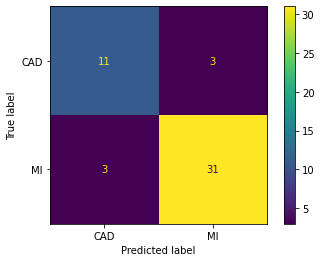

In [37]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(final_xgb, X_test, y_test, values_format='d', display_labels=["CAD", 'MI'])

In [38]:
pred=final_xgb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.91      0.91      0.91        34

    accuracy                           0.88        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.88      0.88      0.88        48



In [ ]:
# Extracting Model File

pickle_out=open('svm_8008885_7971661.pkl', "wb")
pickle.dump(svm_7971661, pickle_out)
pickle_out.close()

#### Testing on test data

In [39]:
label_encoder=LabelEncoder()
label_encoder = label_encoder.fit(y_final_test)
y_binary_final_test = label_encoder.transform(y_final_test)

y_binary_final_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


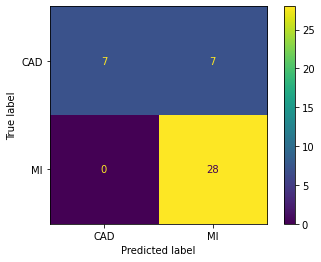

In [40]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(final_xgb, X_final_test[[7916984, 8008885, 8087881]], y_binary_final_test, values_format='d', display_labels=["CAD", 'MI'])

In [41]:
pred=final_xgb.predict(X_final_test[[7916984, 8008885, 8087881]])
print(classification_report(y_binary_final_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        14
           1       0.80      1.00      0.89        28

    accuracy                           0.83        42
   macro avg       0.90      0.75      0.78        42
weighted avg       0.87      0.83      0.81        42



# SVM

In [48]:
svm=SVC(kernel="linear", random_state=1)
svm.fit(X_train, y_train)
svm.score(X_train, y_train), svm.score(X_test, y_test)

(0.8990825688073395, 0.8125)

In [56]:
pd.DataFrame(svm.coef_, columns=X_train.columns, index=['Feature Importance'])

Unnamed: 0,7900488,7916984,7923976,7969574,7971661,8008885,8084755,8087881,8163107
Feature Importance,0.392989,-0.676756,-0.328409,0.634798,-1.074674,1.646753,-0.975243,-1.680179,1.003489


In [134]:
X_temp=X[[8087881, 8008885, 7971661]]

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.3, random_state=2, stratify=y)

X_train.shape, X_test.shape

((109, 3), (48, 3))

In [135]:
svm=SVC(kernel="rbf", random_state=1)
svm.fit(X_train, y_train)
svm.score(X_train, y_train), svm.score(X_test, y_test)

(0.8532110091743119, 0.7916666666666666)

## Optimization

In [136]:
# determine the hyperparameter space

param_grid = [
    Real(0.1, 100, name='C'),
    Categorical(['rbf', 'linear', 'sigmoid'], name='kernel'),
    Real(0.001, 1, name='gamma')
]

In [137]:
# set up SVM

svm=SVC(random_state=1)

In [138]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    svm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            svm, 
            X_train,
            y_train,
            cv=10,
            n_jobs=-1,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

### Bayesian Optimization

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization.

In [139]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=200, # the number of subsequent evaluations of f(x)
    random_state=0
)

In [140]:
"Best score=%.4f" % gp_.fun

'Best score=-0.8809'

In [141]:
print("""Best parameters:
=========================
- C = %.4f
- kernel = %s
- gamma = %.6f
""" % (gp_.x[0],
       gp_.x[1],
       gp_.x[2]
      ))

Best parameters:
- C = 86.5769
- kernel = rbf
- gamma = 1.000000



In [143]:
sample_weight=np.zeros(len(y_train))
for i in range(0, 100):
    a=0.05
    a+=i*0.05
    sample_weight[y_train == 'M'] = a
    sample_weight[y_train == 'C'] = 1
    svm=SVC(kernel="rbf",
            C=86.58,
            gamma=1,
            random_state=1,
           # class_weight=weights
           )
    svm.fit(X_train, y_train, sample_weight=sample_weight)
    print('%.2f' % a, '%.3f' % svm.score(X_train, y_train), '%.3f' % svm.score(X_test, y_test),
         '%.3f' % svm.score(X_final_test[[8087881, 8008885, 7971661]], y_final_test))

0.05 0.844 0.771 0.810
0.10 0.881 0.771 0.810
0.15 0.917 0.708 0.810
0.20 0.927 0.667 0.810
0.25 0.936 0.688 0.833
0.30 0.936 0.729 0.857
0.35 0.927 0.729 0.833
0.40 0.927 0.729 0.833
0.45 0.927 0.729 0.810
0.50 0.917 0.729 0.786
0.55 0.927 0.708 0.810
0.60 0.936 0.708 0.810
0.65 0.945 0.708 0.810
0.70 0.945 0.708 0.810
0.75 0.954 0.729 0.833
0.80 0.954 0.729 0.833
0.85 0.954 0.729 0.833
0.90 0.945 0.729 0.833
0.95 0.945 0.750 0.833
1.00 0.936 0.750 0.833
1.05 0.927 0.771 0.833
1.10 0.927 0.750 0.833
1.15 0.927 0.750 0.833
1.20 0.936 0.729 0.833
1.25 0.936 0.729 0.833
1.30 0.945 0.729 0.833
1.35 0.945 0.750 0.833
1.40 0.945 0.771 0.833
1.45 0.945 0.771 0.833
1.50 0.945 0.792 0.833
1.55 0.945 0.792 0.833
1.60 0.945 0.792 0.833
1.65 0.945 0.792 0.833
1.70 0.945 0.792 0.833
1.75 0.945 0.792 0.833
1.80 0.945 0.792 0.833
1.85 0.945 0.792 0.833
1.90 0.945 0.792 0.833
1.95 0.945 0.792 0.833
2.00 0.945 0.792 0.833
2.05 0.945 0.792 0.833
2.10 0.945 0.792 0.833
2.15 0.945 0.792 0.833
2.20 0.945 

In [144]:
sample_weight=np.zeros(len(y_train))
sample_weight[y_train == 'M'] = 3
sample_weight[y_train == 'C'] = 1

In [146]:
svm=SVC(kernel="rbf",
            C=87,
            gamma=1.0,
            random_state=1,
            class_weight={'C':1, 'M':3})
cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(svm, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.867


In [147]:
svm=SVC(kernel="rbf",
            C=87,
            gamma=1.0,
            random_state=1,
            class_weight={'C':1, 'M':3})
svm.fit(X_train, y_train)
svm.score(X_train, y_train), svm.score(X_test, y_test), svm.score(X_final_test[[8087881, 8008885, 7971661]], y_final_test)

(0.9541284403669725, 0.8333333333333334, 0.8571428571428571)

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


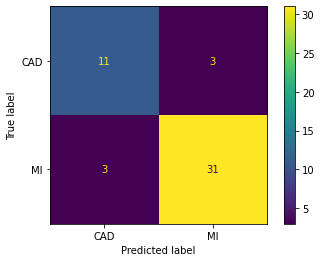

In [37]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, X_test, y_test, values_format='d', display_labels=["CAD", 'MI'])

In [112]:
pred=svm.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           C       0.67      0.86      0.75        14
           M       0.93      0.82      0.87        34

    accuracy                           0.83        48
   macro avg       0.80      0.84      0.81        48
weighted avg       0.86      0.83      0.84        48



#### Testing on test data

/Users/mehrdad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


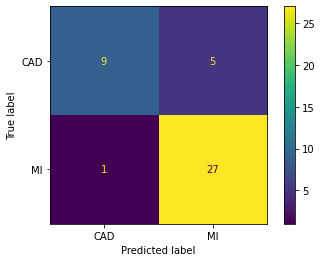

In [113]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(svm, X_final_test[[8087881, 8008885, 7971661]], y_final_test, values_format='d', display_labels=["CAD", 'MI'])

In [116]:
pred=svm.predict(X_final_test[[8087881, 8008885, 7971661]])
print(classification_report(y_final_test, pred))

              precision    recall  f1-score   support

           C       0.90      0.64      0.75        14
           M       0.84      0.96      0.90        28

    accuracy                           0.86        42
   macro avg       0.87      0.80      0.82        42
weighted avg       0.86      0.86      0.85        42



# ANN